# Lab 01 Machine Learning: Regression



Existen dos tipos de aprendisaje supervisado en Machine Learining: Regresión y Clasificación. La primera predice valores continuos y la segunda predice valores discretos. En este notebook nos enfocaremos en la Regresión. 

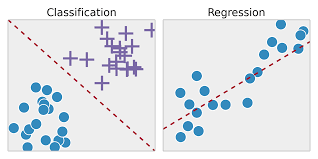

La regresión es un metodo que modela una variable *target* basandose en otras variables. Como predice valores continuos, este metodo se utiliza para predecir el precios ,calcular probabilidades, encontrar relaciones causa-efecto entre variables, etc. Existen distintos modelos para realizar una regresión, la mayoria se diferencian por el número de variables independientes y el tipo de relación que tienen estas variables con la variable dependiente.

A continuación haremos un ejemplo siguiendo todos los pasos necesarios para una regresión:

- [Importación de paquetes](#Importación-de-paquetes)
- [Lectura de datos](#Lectura-de-datos)
- [Análisis exploratorio](#Análisis-exploratorio)
- [Preprocesado de Datos](#Preprocesado-de-Datos.)
- [Obtención del conjunto de entrenamiento y test](Obtención-del-conjunto-de-entrenamiento-y-test)
- [Construcción de modelos](#Construcción-de-modelos)
- [Entrenamiento en Azure](#Entrenamiento-en-Azure)

### Importación de paquetes

En primer lugar, hemos de importar los paquetes que vamos a necesitar para este Laboratorio. Para ello, estos han de ser sido previamente instalados en nuestro sistema.

In [12]:
import sys
import pandas as pd
import numpy as np
from joblib import dump
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Workspace, Run
from azureml.core.experiment import Experiment

In [18]:
from IPython.display import Javascript, display,HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## ¿Cuantás ventas tendremos?

En el ejemplo de hoy utilizaremos datos obtenidos por una agencia publicitaria en una campaña publicitaria. Dentro de la campaña que se llevó acabo, se contabilizó el dinero invertido en anuncios de television, redes sociales y radio para dos tipos distintos de anuncios y el número de ventas que estas variables generaron. Nosotros buscaremos encontrar un modelo que sea capaz de aprender a predecir cuantas ventas tendremos según cuanto dinero invirtamos en los distintos medios.

### Lectura de datos
A continuación cargaremos el conjunto de datos y mostraremos algunos ejemplos del dataset:

In [13]:
data_path="data/Advertising.csv"
df = pd.read_csv(data_path, sep=',')
df= df.drop('Unnamed: 0', axis=1)
df.head()

,TV,radio,social_media,sales,ad_type
0,230.1,37.8,69.2,22.1,1
1,44.5,39.3,45.1,10.4,2
2,17.2,45.9,69.3,9.3,1
3,151.5,41.3,58.5,18.5,1
4,180.8,10.8,58.4,12.9,2



## Análisis Exploratorio

Dentro de un proceso de Machine Learning el primer paso es analizar el conjunto de datos que tenemos. Poder observar las caracteristicas generales del mismo y poder entender los datos y la relacion que existe entre las distintas variables. De esta manera podemos generar hipotesis que nos ayuden a desarrollar nuestro modelo predictivo.

Además es importante ver la calidad de nuestros datos, de ellos depende que tengamos un buen modelo predictivo ¿Parece que existe un problema de recopilación de datos? ¿El formato de los datos coincide con lo que quiero hacer con ellos? ¿Hay más valores que faltan?, etc.

Al realizar el analisis exploratorio es importarte guiarse en el objetivo a resolver, para conducir el analisis en dirección a encontrar información relevante para nuestro problema. 

#### ¿Qué tipo de datos tiene nuestro dataset?

In [14]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
TV              200 non-null float64
radio           200 non-null float64
social_media    200 non-null float64
sales           200 non-null float64
ad_type         200 non-null int64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


(200, 5)

Vemos que nuestro conjunto de datos tiene un total de 200 filas y 5 columnas. En estas cinco columnas tenemos nuestra variable **target** que es la que queremos predecir: ``sales``.

#### Detalles estadísticos de nuestro conjunto de datos

In [15]:
df.describe()

,TV,radio,social_media,sales,ad_type
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500,1.400000
std,85.854236,14.846809,21.778621,5.217457,0.491127
min,0.700000,0.000000,0.300000,1.600000,1.000000
25%,74.375000,9.975000,12.750000,10.375000,1.000000
50%,149.750000,22.900000,25.750000,12.900000,1.000000
75%,218.825000,36.525000,45.100000,17.400000,2.000000
max,296.400000,49.600000,114.000000,27.000000,2.000000


## Correlacion de variables

Conocer la correlación entre las variables nos ayuda a entender las relaciones entre las mismas. Una correlación elevada implica que existe una relación entre ambas variables. En general, es recomendable incluir variables con una correlación alta al entrenar nuestros modelos porque son las que tienen mayor poder predictivo. También, se recomienda omitir variables con una correlación baja porque es probable que sean irrelevantes.

Para ello se calcularemos la matriz de correlación para el conjunto total de nuestros datos. La matriz de correlaciones es una matriz en la cual cada entrada presenta el coeficiente de correlación entre dos variables.

El coeficiente de correlación es una medida estadística que permite conocer el grado de asociación lineal entre dos variables cuantitativas  (X,Y)(X,Y) . Éste se calcula como la covarianza de dos variables dividida por el producto de la desviación típica de cada una de las muestras. Es la normalización de la covarianza entre dos variables.

El coeficiente de correlación toma valores entre  −1−1  y  11 . Si el valor del coeficiente de correlación es  11  o próximo a  11 , se dirá que la asociación lineal es positiva (esto es, a medida que crece una de las variables crece la otra), de la misma forma, cuando el valor es próximo a  −1−1 , se dice que la asociación lineal es negativa. La matriz de correlación se representará empleando un mapa de colores, lo que permite ver a simple vista el grado de correlación entre las distintas variables.

Podemos ver que la correlación mas alta con el target es con la variable television, seguido de el radio y por ultimo las redes sociales. Tambien podemos ver que no existe correlación entre el tipo de anuncio y nuestro target.

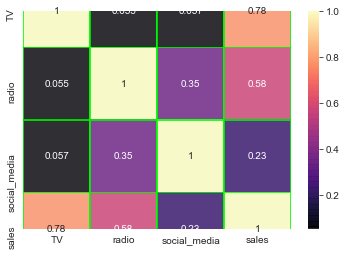

In [32]:
sns.heatmap(df.corr(),cmap = 'magma',lw = .7,linecolor = 'lime',alpha = 0.8,annot = True)

## Histograma de las ventas

Debido a que estamos utilizando variables numericas, podemos ver los valores que toma nuestro target con ayuda de un histrograma. Esta gráfica nos permite analizar la distrubución que tienen nuestros datos:

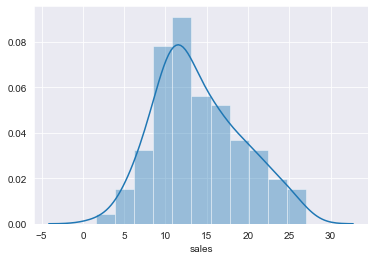

In [11]:
sns.distplot(df['sales'],hist = True)

Tambien podemos analizar la relación de cada variable con el target de manera independiente: 

#### Ventas y anuncios en la television

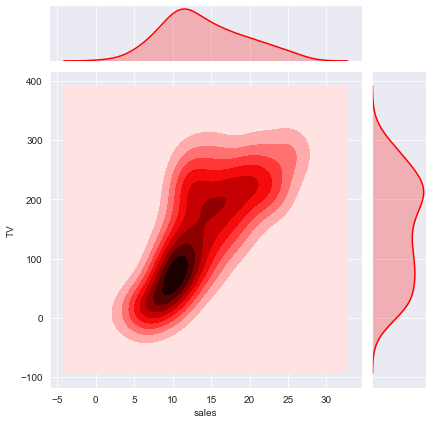

In [12]:
sns.jointplot(x = 'sales',y = 'TV',data = df,kind = 'kde',color = 'red')

####  Ventas y anuncios en el periódico

C:\Users\dsolis\AppData\Local\anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'hist'
  s)


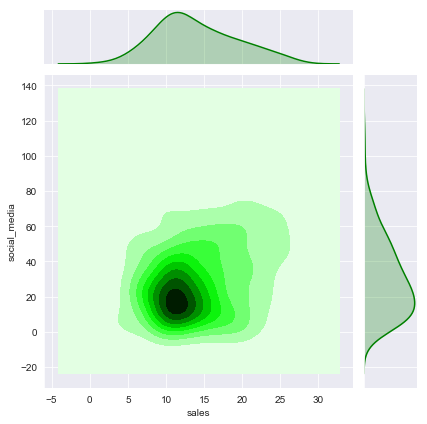

In [8]:
sns.jointplot(x = 'sales',y = 'social_media',data = df,kind = 'kde',color = 'green',hist = True)


#### Ventas y anuncios en el radio

C:\Users\dsolis\AppData\Local\anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'hist'
  s)


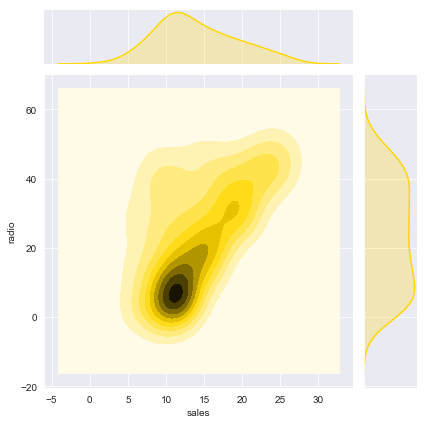

In [9]:
sns.jointplot(x = 'sales',y = 'radio',data = df,kind = 'kde',color = 'gold',hist = True)


Por ultimo podemos pintar una *pair plot* para obtener una idea mas general de todas las variables, vemos la distribucion de cada una de las variables en sus histrogramas además de la relacion en pares de las variables. Esta gráfica nos permite observar relaciones interesantes, por ejemplo  podemos observar una correlacion positiva muy clara entre las ventas y el gasto en la television.

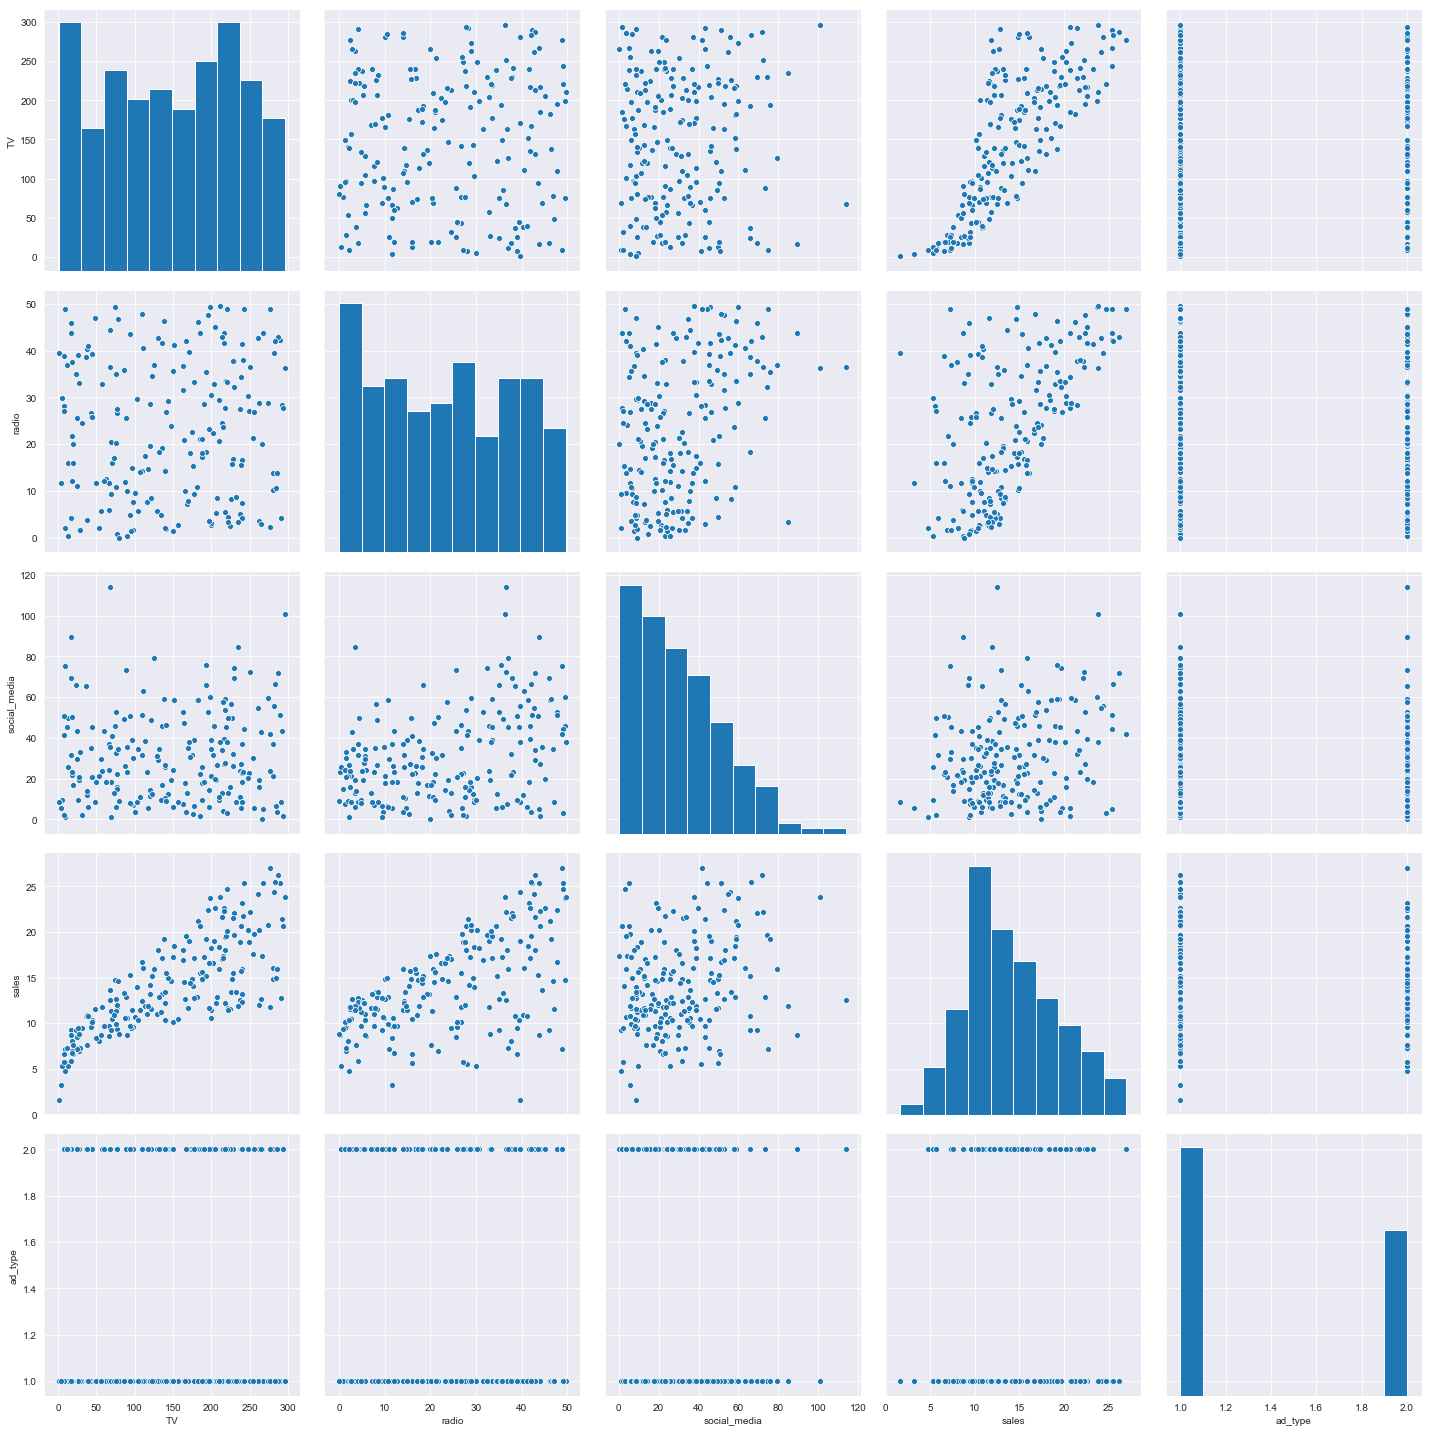

In [10]:
sns.pairplot(df,height = 4)

##  Preprocesado de Datos.

### Selección de variables 

Como vimos en el analisis exploratorio. La correlación de las variables es importante para seleccionar las variables que utilizaremos para entrenar a nuestro modelo. Si vemos el tipo de anuncio no tiene correlacion con el target (sales). Esto significa que no aportara valor al modelo, por lo que podemos descartar este dato. Sin embargo el resto de variables aportan información con lo cual decidimos dejarlas. 

In [16]:
df=  df.drop(['ad_type'],axis = 1)
df.head()

,TV,radio,social_media,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


### Obtención del conjunto de entrenamiento y test

Dividiremos nuestros datos en los 3 conjuntos que mencionas:

Entrenamiento: Este conjunto será utilizado para construir nuestros modelos.
Test: Es una última porción que se mantiene aparte y sobre la cual se evalua el modleo. Usualmente se reporta la eficacia del modelo según los resultados en este conjunto. 

Los porcentajes suelen variar. Los datos de entrenamiento suelen ser la mayoría (50% o más, usualmente hasta un 80%). 

Ademas de estos conjuntos durante el entrenamiento utilizaremos una Validación cruzada de K iteraciones. 

En la validación cruzada de K iteraciones o K-fold cross-validation, subdividimos nuestro conjunto de entrenamiento en en K subconjuntos. Uno de los subconjuntos se utiliza como datos de prueba y el resto (K-1) como datos de entrenamiento. El proceso de validación cruzada es repetido durante k iteraciones, con cada uno de los posibles subconjuntos de datos de prueba. Esto nos ayuda monitorizar el entrenamiento y evitar que el modelo sobre o infra-ajuste:

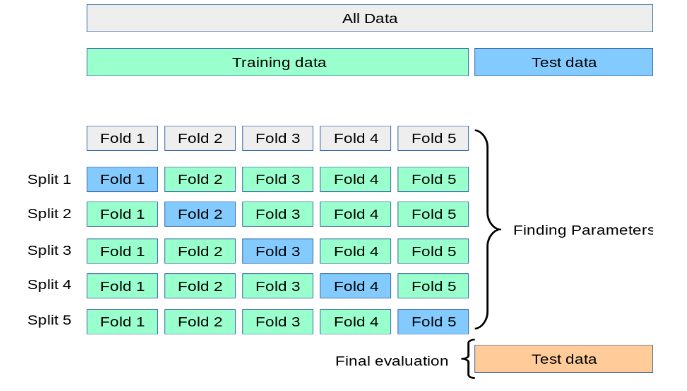

* Se le llama ``overfitting`` al sobreentrenamiento de un modelo, esto ocurre cuando el modelo se memoriza los datos y ya no es capáz de generalizar. Si esto ocurre el modelo no será capaz de dar buenos resultados con nuevos datos. 
* se le llama ``underfitting`` a un modelo que no ha sido entrenado suficientemente con lo cual no ha sido capaz de abstraer las relacciones de los datos necesarias para poder hacer buenas predicciones. 

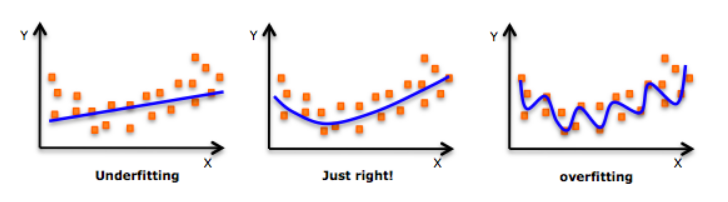

### Mezclar de manera aleatoria el orden de las muestras

Es importante ordenar de manera aleatoria los ejemplos en nuestro dataset.  Puede ser que si nuestro dataset está ordenado dependiendo de por ejemplo el dia del año y es posible que las ventas sean distintas dependiendo de la temporada del año. Como dividiremos nuestro conjunto de datos es conveniente dividir los datos de manera aleatoria para tener todo tipo de ejemplos en cada uno de los subconjuntos de datos.

In [17]:
x = df.drop(['sales'] ,axis = 1)
y = df['sales']

msk = np.random.rand(len(df)) < 0.8

x_train = x[msk]
y_train= y[msk]

x_test = x[~msk]
y_test = y[~msk]


## Construcción de modelos

### No Free Lunch Theorem 

Cuando resolvemos un problema utilizando Machine Learning tenemos que tener en cuenta el teorema de *No free lunch*. Este dice que no existe un único algoritmo que funcione bien para todos los problemas. Cada problema que queramos resolver tiene sus propias caracteristicas. Por lo tanto, es posible resolverlo de distintas maneras, algunas daran mejores resultados que otras y muchas veces no podemos saber que algoritmo va a funcionar mejor a prior. Es posible seleccionar un grupo de algoritmos que sabemos que se adaptan a las caracteristicas del problema, pero la seleccion del mejor modelo solo la podremos hacer una vez que hemos probado. Por lo tanto a continuación entrenaremos varios modelos: . 

### Modelo Linear Regressor

Este modelo intenta encontrar la relación lineal entre las variables dependientes, en este caso ``television``, ``radio`` y ``social_media`` con el target ``sales``. Si simplificaramos nuestro problema al caso mas sencillo en un espacio 2D, este algoritmo intentaria encontrar la linea recta que mejor describiera los datos, de ahi viene su nombre **Linear Regression**:

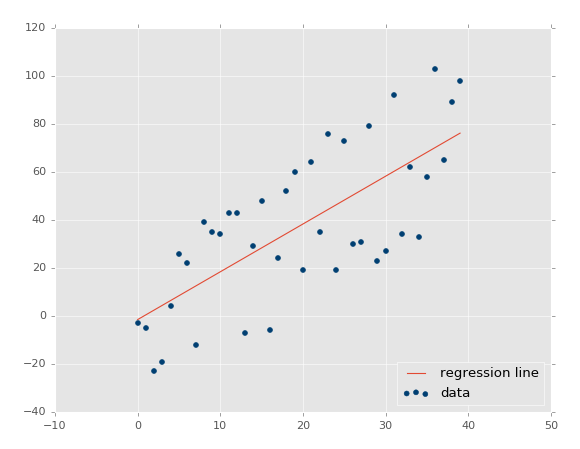

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
kf = KFold(n_splits=3) 

for train_index, test_index in kf.split(x_train):
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    reg.fit(X, Y)
    pred=reg.predict(X_val)
    r2 = r2_score(Y_val, pred)
    print('validation R2:'+ str(r2))

pred=reg.predict(x_test)
error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test, pred)
print(r2)

validation R2:0.9126984645131518
validation R2:0.8575918569304912
validation R2:0.8791043625448369
0.9032375931924065


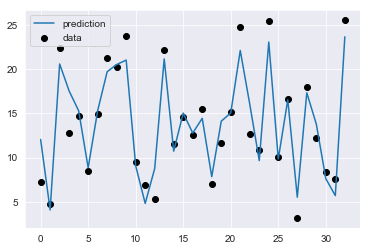

In [14]:
plt.scatter(range(len(x_test)), y_test,  c='k',label='data')
plt.plot(range(len(x_test)), pred, label='prediction')
plt.axis('tight')
plt.legend()

### Modelo KNN

Este modelo utiliza la similitud de las variables *‘feature similarity’* para predecir nuevos valores. Dado un nuevo conjunto de datos, calculará el target basandose en que tanto se parece este nuevo conjunto de datos a los datos del conjunto de entrenamiento. 

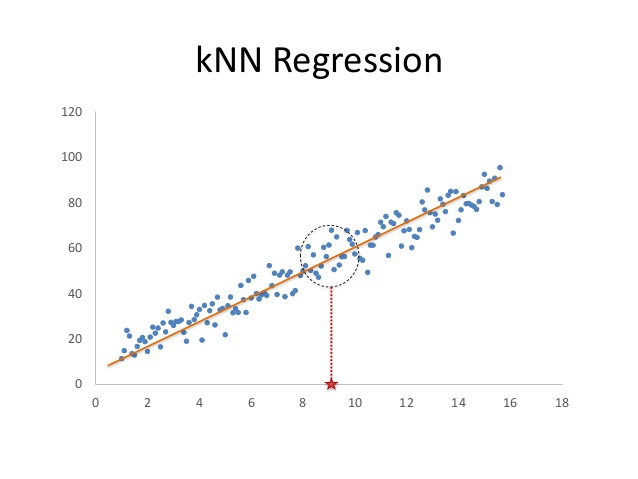

In [15]:
knn = KNeighborsRegressor(n_neighbors=2)

kf = KFold(n_splits=3) 

for train_index, test_index in kf.split(x_train):
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    knn.fit(X, Y)
    pred=knn.predict(X_val)
    r2 = r2_score(Y_val, pred)
    print('validation R2:'+ str(r2))


validation R2:0.8952229145558267
validation R2:0.8914080108824084
validation R2:0.8259005834382167


In [16]:
pred=knn.predict(x_test)
error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test, pred)

In [17]:
print(r2)

0.8694659299718044


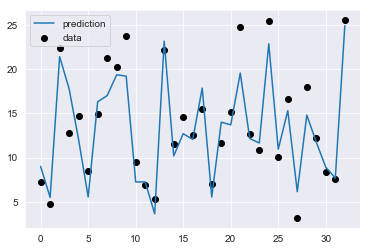

In [18]:
plt.scatter(range(len(x_test)), y_test, c='k', label='data')
plt.plot(range(len(x_test)), pred, label='prediction')
plt.axis('tight')
plt.legend()

### Random Forest Regressor

Este algoritmo utiliza conjuntos de arboles de decision para dar una predicción.

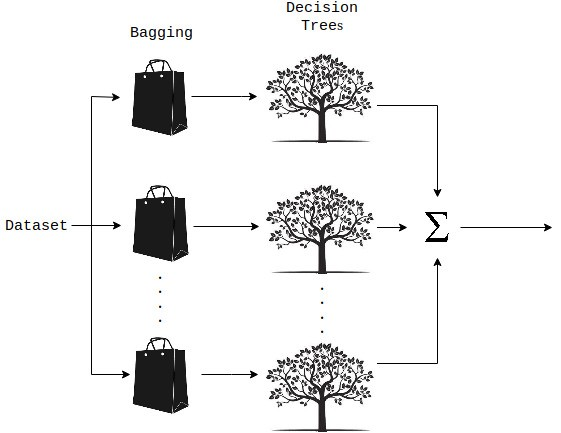

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

kf = KFold(n_splits=4) 

for train_index, test_index in kf.split(x_train):
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    rf.fit(X, Y)
    pred=rf.predict(X_val)
    r2 = r2_score(Y_val, pred)
    print('validation R2:'+ str(r2))

validation R2:0.9711435028094298
validation R2:0.9458451805635013
validation R2:0.9505634664591195
validation R2:0.967853468507555


In [20]:
pred=rf.predict(x_test)
error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test, pred)
print(r2)

0.9678270960622428


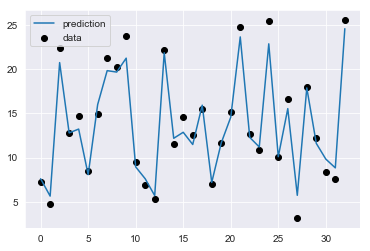

In [21]:
plt.scatter(range(len(x_test)), y_test, c='k', label='data')
plt.plot(range(len(x_test)), pred, label='prediction')
plt.axis('tight')
plt.legend()

### Entrenamiento en Azure

Ahora repetiremos el entrenamiento de nuestros modelos en Azure.

In [20]:
ws = Workspace.from_config(path="config/azureml_ws.json")

Found the config file in: C:\Users\rodri\Documents\code\WorkshopAIMadridDay2\config\azureml_ws.json


In [22]:
def train(model, model_name, k=3):
    kf = KFold(n_splits=3) 
    i=0
    for train_index, test_index in kf.split(x_train):
        i=i+1
        X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(X, Y)
        pred=model.predict(X_val)
        r2 = r2_score(Y_val, pred)
        root_run.log('Fold validation R2:', r2)

    pred=model.predict(x_test)
    error = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test, pred)

    root_run.log("Mean_squared_error", error)    
    root_run.log("R2", r2)

    dump(model, model_name)

    root_run.upload_file("outputs/" + model_name, model_name)
    root_run.register_model(model_name=model_name, model_path='outputs/' + model_name)
    root_run.complete()

### Entrenamiento de Linear Regressor

In [24]:
experiment_name = 'day2-linearregression'
model_name = 'linearregressor'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging()
reg = LinearRegression()
train(reg, model_name)

### Entrenamiento KNN

In [23]:
experiment_name = 'day2-KNNregression'
model_name = 'KNNregressor'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging()
knn = KNeighborsRegressor(n_neighbors=2)
train(knn, model_name)

### Entrenamiento Random Forest

In [26]:
experiment_name = 'day2-RandomForestRegression'
model_name = 'RandomForestregressor'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging()
rf = RandomForestRegressor()
train(rf, model_name)